In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import re
import string


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Load from data folder
fake_df = pd.read_csv('/content/drive/MyDrive/Fake_news_detection/Fake.csv')
true_df = pd.read_csv('/content/drive/MyDrive/Fake_news_detection/True.csv')


In [5]:
# Inspect data

print("Fake News Data")
print(fake_df.shape)
print(fake_df.columns)
print(fake_df.head(2))

print("\nTrue News Data")
print(true_df.shape)
print(true_df.columns)
print(true_df.head(2))


Fake News Data
(23481, 4)
Index(['title', 'text', 'subject', 'date'], dtype='object')
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  

True News Data
(21417, 4)
Index(['title', 'text', 'subject', 'date'], dtype='object')
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   

                

In [6]:
fake_df['label'] = 0  # 0 = FAKE
true_df['label'] = 1  # 1 = REAL

df = pd.concat([fake_df, true_df], ignore_index=True)
df = df[['text', 'label']]  # Keep only 'text' and 'label'


In [7]:
# Clean Missing & Duplicate Values

# Missing values
print(df.isnull().sum())

# Remove nulls
df.dropna(inplace=True)

# Check for duplicates
print("Duplicate Rows:", df.duplicated().sum())

# Remove duplicates
df.drop_duplicates(inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)


text     0
label    0
dtype: int64
Duplicate Rows: 6251


In [8]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)


In [9]:
print("After Cleaning:")
print("Missing Values:\n", df.isnull().sum())
print("Duplicate Rows:", df.duplicated().sum())
print("Shape:", df.shape)


After Cleaning:
Missing Values:
 text     0
label    0
dtype: int64
Duplicate Rows: 0
Shape: (38647, 2)


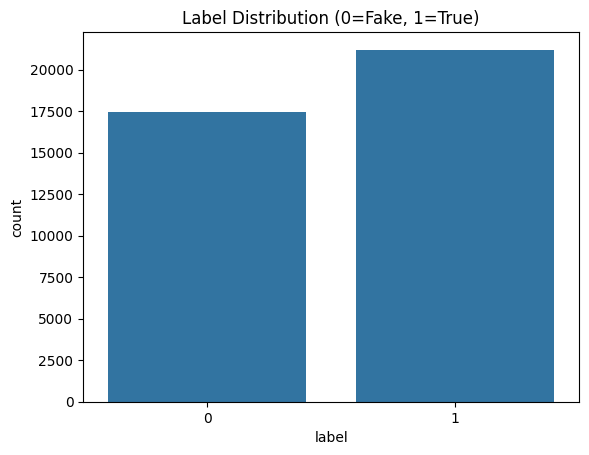

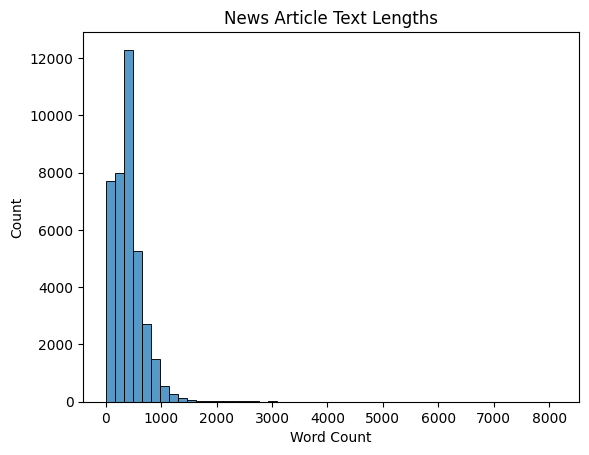

In [10]:
# Label distribution
sns.countplot(data=df, x='label')
plt.title("Label Distribution (0=Fake, 1=True)")
plt.show()

# Text length
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=50)
plt.title("News Article Text Lengths")
plt.xlabel("Word Count")
plt.show()


In [11]:
# Tokenize - Text ko numbers mein convert karna, taaki machine samajh sake.

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])


In [12]:
# Text to Sequences + Padding - Har sentence ki length alag hoti hai. Model ko chahiye equal length inputs.

from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=500)


In [13]:
# Encode Labels

import numpy as np
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])  # fake = 0, real = 1
labels = np.array(labels)


In [14]:

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels,
    test_size=0.2,
    random_state=42
)


In [15]:
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Train data shape: (30917, 500)
Test data shape: (7730, 500)


# LSTM Model building

In [16]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=500))
model.add(LSTM(64, return_sequences=False))     # Core of deep learning model
model.add(Dropout(0.5))       # Prevents overfitting
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# Compile the Model

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)



In [18]:
# Train the model

history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    batch_size=64
)


Epoch 1/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 227s 461ms/step - accuracy: 0.6704 - loss: 0.6143 - val_accuracy: 0.9395 - val_loss: 0.2419
Epoch 2/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 272s 484ms/step - accuracy: 0.9078 - loss: 0.2615 - val_accuracy: 0.6690 - val_loss: 0.5296
Epoch 3/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 225s 466ms/step - accuracy: 0.6722 - loss: 0.5362 - val_accuracy: 0.9432 - val_loss: 0.2451
Epoch 4/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 256s 453ms/step - accuracy: 0.9616 - loss: 0.1609 - val_accuracy: 0.8999 - val_loss: 0.4014
Epoch 5/5
484/484 ━━━━━━━━━━━━━━━━━━━━ 258s 446ms/step - accuracy: 0.8349 - loss: 0.4389 - val_accuracy: 0.9774 - val_loss: 0.0624


In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9779 - loss: 0.0607
Test Accuracy: 0.9774


In [30]:
model.save("fake_news_model.h5")


#  Visualize Training Metrics

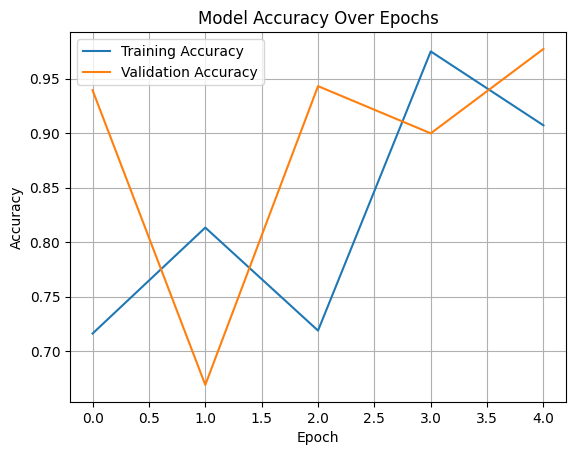

In [21]:
# Code to Plot Accuracy:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



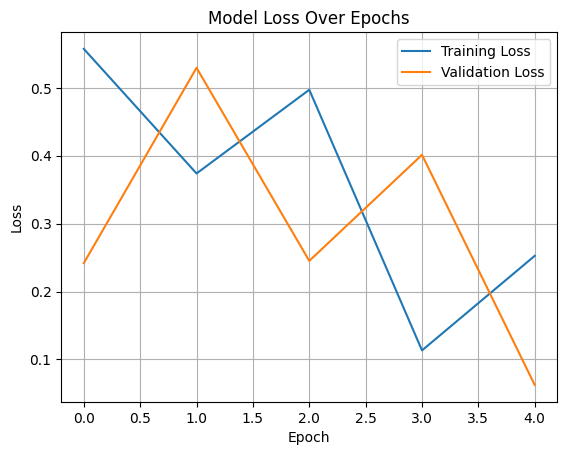

In [22]:
# Code to Plot Loss:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Interpret Model Predictions

242/242 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step


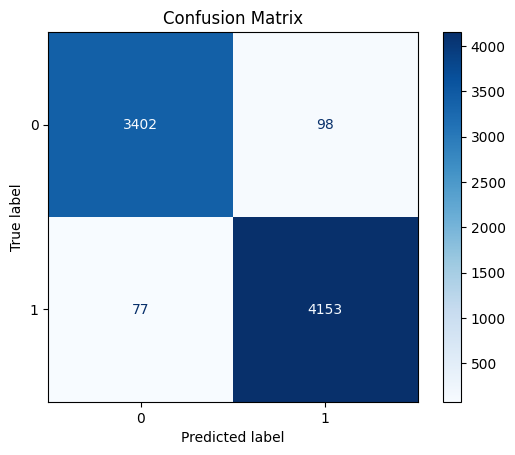

In [23]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [31]:
# Classification Report

from sklearn.metrics import classification_report

# Map integer labels back to original class names
target_names = ['fake', 'real']

print(classification_report(y_test, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

        fake       0.98      0.97      0.97      3500
        real       0.98      0.98      0.98      4230

    accuracy                           0.98      7730
   macro avg       0.98      0.98      0.98      7730
weighted avg       0.98      0.98      0.98      7730



In [32]:
model.save("fake_news_model.keras")

#Extra Insights: Subject/Keyword Analysis of News


In [33]:
fake_texts = df[df['label'] == 0]['text']
true_texts = df[df['label'] == 1]['text']


In [34]:
import re

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Remove numbers/punctuation
    return text

fake_clean = fake_texts.apply(clean_text)
true_clean = true_texts.apply(clean_text)


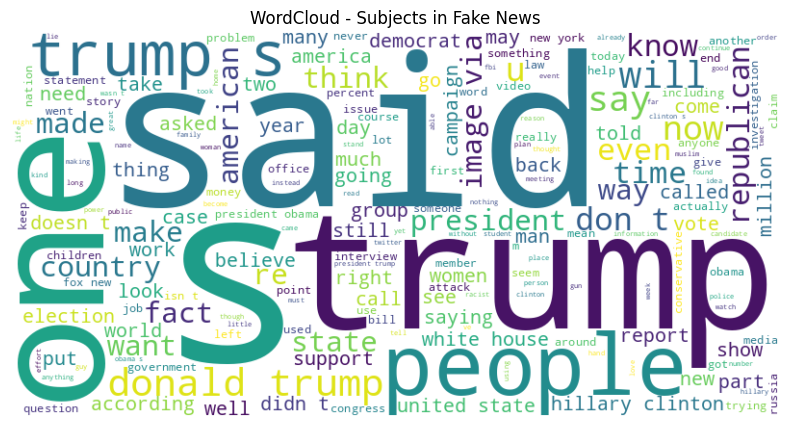

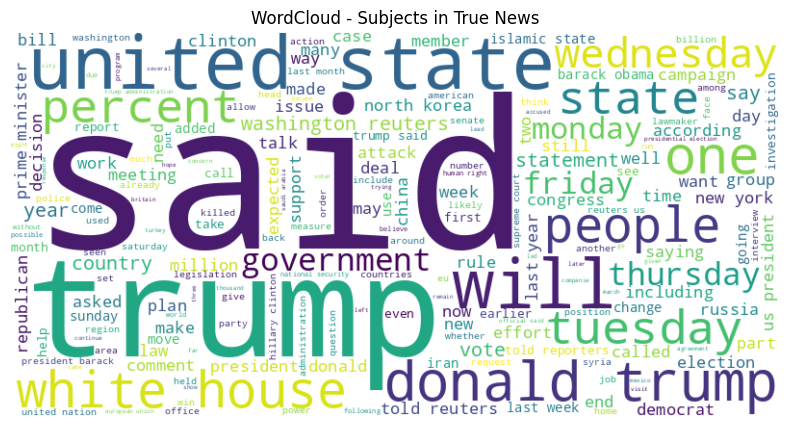

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fake News WordCloud
wc_fake = WordCloud(width=800, height=400, background_color='white').generate(" ".join(fake_clean))
plt.figure(figsize=(10,5))
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Subjects in Fake News')
plt.show()

# True News WordCloud
wc_true = WordCloud(width=800, height=400, background_color='white').generate(" ".join(true_clean))
plt.figure(figsize=(10,5))
plt.imshow(wc_true, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Subjects in True News')
plt.show()


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF for Fake
tfidf_vectorizer_fake = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_vectorizer_fake.fit_transform(fake_clean)
fake_keywords = tfidf_vectorizer_fake.get_feature_names_out()

# TF-IDF for True
tfidf_vectorizer_true = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_vectorizer_true.fit_transform(true_clean)
true_keywords = tfidf_vectorizer_true.get_feature_names_out()

# Print Keywords
print("Top 20 Keywords in Fake News:\n", fake_keywords)
print("\n Top 20 Keywords in True News:\n", true_keywords)


Top 20 Keywords in Fake News:
 ['campaign' 'clinton' 'donald' 'going' 'hillary' 'house' 'image' 'just'
 'know' 'like' 'new' 'news' 'obama' 'people' 'president' 'said' 'state'
 'time' 'trump' 'white']

 Top 20 Keywords in True News:
 ['campaign' 'donald' 'election' 'government' 'house' 'new' 'party'
 'people' 'president' 'republican' 'reuters' 'said' 'state' 'states'
 'told' 'trump' 'trumps' 'united' 'washington' 'year']
